In [7]:
import os
import sys
from pathlib import Path
sys.path.insert(1, os.path.realpath(os.path.pardir))

import torch
import torch.nn.functional as F
from torch import nn
import safetensors
import einops

from utils.data_utils import BrainDataset, get_tokenizer
from utils.train_utils import TrainConfig, run_train_model, count_parameters, load_model_weights

from dataclasses import dataclass
from simple_parsing.helpers import Serializable

In [19]:
from peft import LoraConfig
from peft import get_peft_model

from transformers import GPT2Tokenizer
from models.gpt2_model import GPT
import tiktoken
from contextlib import nullcontext
from accelerate import notebook_launcher

import matplotlib.pyplot as plt
import albumentations as A


In [9]:
from models.bert import BrainBert, BertConfig
from models.vq_brain_per_channel import SoundStream, VAEConfig

In [42]:
# device='cuda'
# device='cuda'
vae_config = VAEConfig(C=256, levels=(8, 8, 6, 5))
vq_vae = SoundStream(**vae_config.to_dict())

vq_weights = "/drive/logs/kovalev/vq_brain/medium_14M_256ws_8x_2000/step_78000_loss_0.0275.safetensors"
vq_vae = load_model_weights(vq_vae, vq_weights)

model_config = BertConfig(dim=256, 
                 window_size=512, 
                 tokenizer_downsample=int(vq_vae.downsample),
                 n_electrodes=256, 
                 mask_ratio=0.25, 
                 n_layers=12, 
                 n_heads=12, 
                 n_kv_heads=12)

model = BrainBert(model_config, vq_vae)

for param in model.tokenizer.parameters():
    param.requires_grad = False 

count_parameters(model)

self.codebook_size 1920
self.downsample 8
load compiled weights
BertConfig(window_size=512, n_electrodes=256, mask_ratio=0.25, tokenizer_downsample=8, n_layers=12, dim=256, hidden_dim=1024, head_dim=32, n_heads=12, n_kv_heads=12)
Encoder: number of parameters: 42.79M
Total: 42.79M, Trainable: 29.39M


(42788997, 29391488)

In [43]:
bert_weights = "/drive/logs/kovalev/bert/new_vqvae_8x_2000_large_bert_30M_0_25/step_6500_loss_1.4677.safetensors"
model = load_model_weights(model, bert_weights)
count_parameters(model)

load default weights
Total: 42.79M, Trainable: 29.39M


(42788997, 29391488)

In [44]:
from einops import rearrange

In [45]:
window_size = model_config.window_size
n_electrodes = 256

train_transform = A.Compose([
    A.PadIfNeeded(min_height=window_size, min_width=n_electrodes, position='top_left', 
                  border_mode=4, value=0, always_apply=True),
    A.RandomCrop(height=window_size, width=n_electrodes, always_apply=True),
])

test_transform = A.Compose([
    A.PadIfNeeded(min_height=window_size, min_width=n_electrodes, position='top_left', 
                  border_mode=4, value=0, always_apply=True),
    A.CenterCrop(height=window_size, width=n_electrodes, always_apply=True),
])

In [46]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

data_path = Path("/drive/data/competitionData")
test_dataset = BrainDataset(data_path / 'test', tokenize_function=get_tokenizer(tokenizer), transform=test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

x, y, date = next(iter(test_dataloader))
print(x.shape, y.shape, date)

with torch.no_grad():
    loss, pred, masked_ids = model(x, y, date, return_indices=True)
    print(loss)
ids = torch.argmax(pred, -1)
reconstruct = model.tokenizer.decode_indices(ids)

/opt/conda/envs/pytorch/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Runed processing of the  /drive/data/competitionData/test
len of the dataset: 880
max input len 919
median len 283.5
torch.Size([1, 512, 256]) torch.Size([1, 25]) tensor([0])


In [48]:
recon = reconstruct.detach()
x = x.detach()

binary_mask = (masked_ids==model.MASK_ID)
binary_mask = torch.repeat_interleave(binary_mask, repeats=model.tokenizer_downsample, dim=1)
binary_mask = binary_mask.detach()

In [49]:
x_masked_input = binary_mask * x
x_unmasked_input = ~binary_mask * x

recon_masked = binary_mask * recon
recon_unmasked = ~binary_mask * recon

In [50]:
binary_mask.float().mean()

tensor(0.2500)

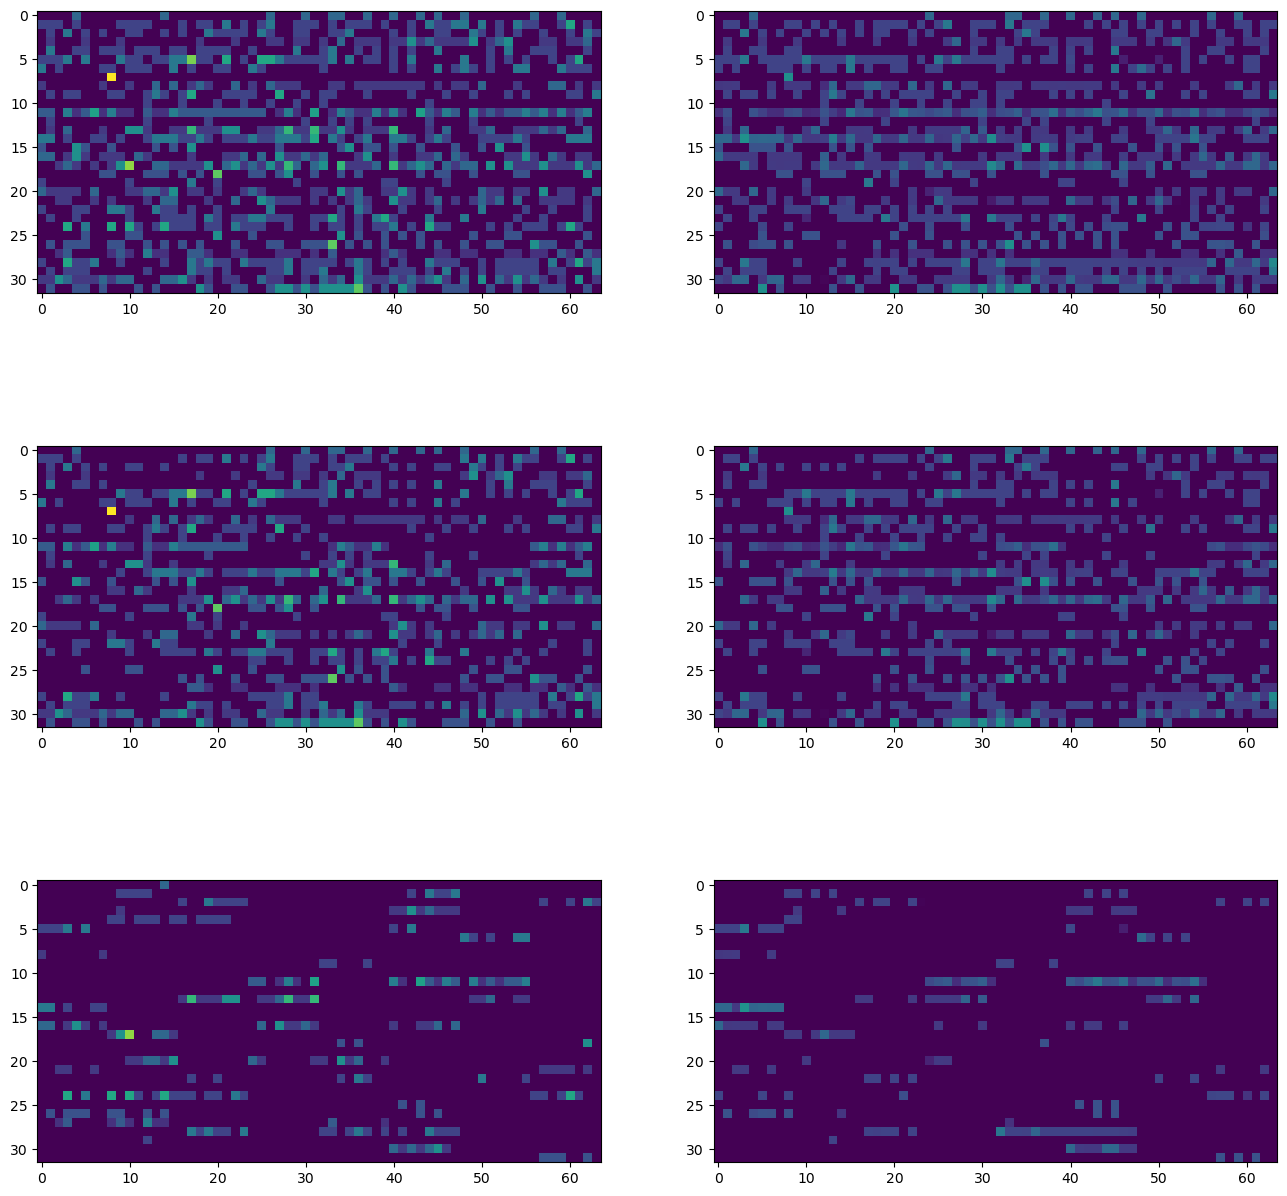

In [72]:
t_st, t_end = 64, 128
c_st, c_end = 0, 32

fig, ax = plt.subplots(3,2, figsize = (16, 16))
ax[0, 0].imshow(x[0, t_st:t_end, c_st:c_end].T, vmax=1)
ax[1, 0].imshow(x_unmasked_input[0, t_st:t_end, c_st:c_end].T, vmax=1)
ax[2, 0].imshow(x_masked_input[0, t_st:t_end, c_st:c_end].T, vmax=1)

ax[0, 1].imshow(recon[0, t_st:t_end, c_st:c_end].T, vmax=1)
ax[1, 1].imshow(recon_unmasked[0, t_st:t_end, c_st:c_end].T, vmax=1)
ax[2, 1].imshow(recon_masked[0, t_st:t_end, c_st:c_end].T, vmax=1)


In [57]:
# x.shape

loss, vq_hat = model.tokenizer(x, return_preds=True)
vq_hat = vq_hat.detach()


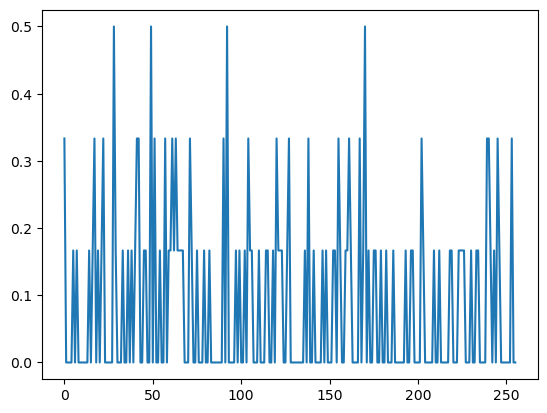

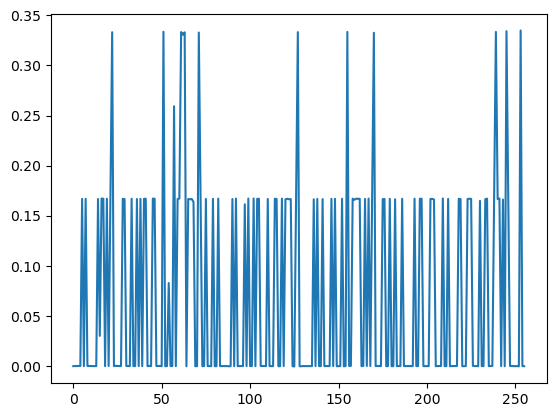

In [65]:
plt.plot(x[0, :256, 33])
plt.show()
plt.plot(vq_hat[0, :256, 33])

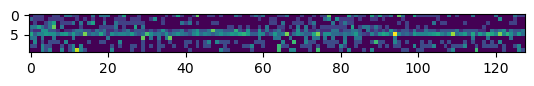

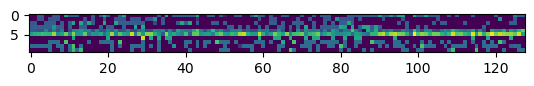

In [84]:
plt.imshow(x[0, :128, 180:190].T)
plt.show()
plt.imshow(vq_hat[0, :128, 180:190].T)

(0.0, 1.0)

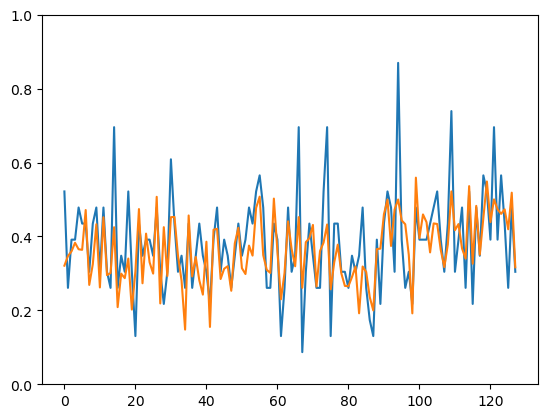

In [89]:
plt.plot(x[0, :128, 185])
plt.ylim(0,1)
# plt.show()
plt.plot(vq_hat[0, :128, 185])
plt.ylim(0,1)